In [1]:
import os
os.chdir('..') #necessary to go one level up to the root directory to find dfm_tools in notebook/binder
import xarray as xr
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import dfm_tools as dfmt


In [2]:
#set paths and parameters per model (change 'model' parameters to get different results/plots)
model = 'grevelingen' #'curvedbend' 'grevelingen' 'westernscheldt'

dir_opendap = 'http://opendap.deltares.nl/thredds/dodsC/opendap/deltares/Delft3D/netcdf_example_files'
if model=='curvedbend':
    file_nc_his = dir_opendap + '/DFM_curvedbend_3D/cb_3d_his.nc'
    file_nc_map = dir_opendap + '/DFM_curvedbend_3D/cb_3d_map.nc'
    layer = 5
    crs = None
    line_array = np.array([[ 104.15421399, 2042.7077107 ],
                           [2913.47878063, 2102.48057382]])
elif model=='grevelingen': #multipart mapfile has to be list in case of opendap
    file_nc_his = dir_opendap + '/DFM_grevelingen_3D/Grevelingen-FM_0000_his.nc'
    file_nc_map = [dir_opendap + f'/DFM_grevelingen_3D/Grevelingen-FM_{i:04d}_map.nc' for i in range(8)]
    layer = 34
    crs = 'EPSG:28992'
    line_array = np.array([[ 53181.96942503, 424270.83361629],
                           [ 55160.15232593, 416913.77136685]])
elif model=='westernscheldt':
    file_nc_his = None
    file_nc_map = dir_opendap + '/westernscheldt_sph_map.nc'
    layer = None
    crs = 'EPSG:4326'
    line_array = None
else:
    raise Exception(f'undefined model: {model}')


In [3]:
#open hisfile with xarray and print netcdf structure
if file_nc_his is not None:
    data_xr_his = xr.open_mfdataset([file_nc_his], preprocess=dfmt.preprocess_hisnc)
    print(data_xr_his)
    stations_pd = data_xr_his['stations'].to_dataframe()
    print('\nStations in netcdf dataset:\n',stations_pd[['station_x_coordinate','station_y_coordinate']])


dropping 45 duplicate "source_sink_name" labels to avoid InvalidIndexError
<xarray.Dataset>
Dimensions:                                       (stations: 24, time: 145,
                                                   laydim: 36, laydimw: 37,
                                                   source_sink_pts: 2,
                                                   source_sink: 1)
Coordinates:
    station_x_coordinate                          (stations) float64 4.747e+0...
    station_y_coordinate                          (stations) float64 4.188e+0...
    zcoordinate_c                                 (time, stations, laydim) float64 dask.array<chunksize=(145, 24, 36), meta=np.ndarray>
    zcoordinate_w                                 (time, stations, laydimw) float64 dask.array<chunksize=(145, 24, 37), meta=np.ndarray>
  * time                                          (time) datetime64[ns] 2007-...
  * stations                                      (stations) <U25 'GTSO-01' ....
  * sour

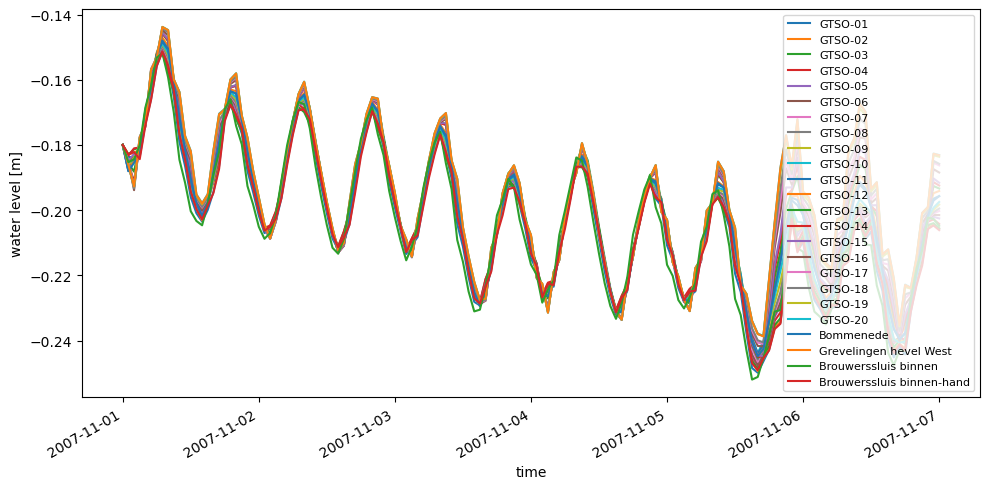

In [4]:
#plot his data: waterlevel at stations
if file_nc_his is not None:
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    data_xr_his.waterlevel.plot.line(ax=ax, x='time')
    ax.legend(data_xr_his.stations.to_series(),loc=1,fontsize=8) #optional, to change legend location
    fig.tight_layout()


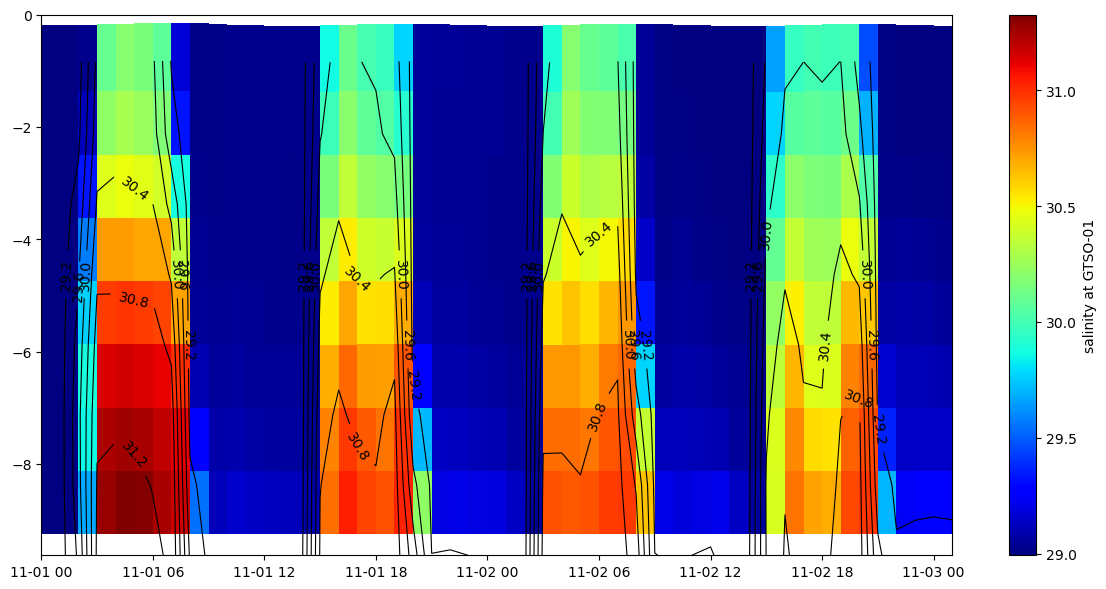

In [5]:
#plot his data: temperature zt at one station
if file_nc_his is not None:
    data_xr_selzt = data_xr_his.isel(stations=0).isel(time=slice(0,50))
    fig, ax1 = plt.subplots(figsize=(12,6))
    c = dfmt.plot_ztdata(data_xr_sel=data_xr_selzt, varname='salinity', ax=ax1, cmap='jet')
    fig.colorbar(c,ax=ax1,label=f'salinity at {data_xr_selzt.stations.data}')
    CS = dfmt.plot_ztdata(data_xr_sel=data_xr_selzt, varname='salinity', ax=ax1, only_contour=True, levels=6, colors='k', linewidths=0.8, linestyles='solid')
    ax1.clabel(CS, fontsize=10)
    fig.tight_layout()

In [6]:
#open mapfile with xarray and print netcdf structure (data_xr_map is not used for now)
if isinstance(file_nc_map,list):
    data_xr_map = xr.open_dataset(file_nc_map[0])
else:
    data_xr_map = xr.open_dataset(file_nc_map)
print(data_xr_map)


<xarray.Dataset>
Dimensions:                      (nmesh2d_node: 3454, nmesh2d_edge: 10032,
                                  Two: 2, nmesh2d_face: 6579,
                                  max_nmesh2d_face_nodes: 3, nmesh2d_layer: 36,
                                  nmesh2d_interface: 37, time: 4)
Coordinates:
    mesh2d_node_x                (nmesh2d_node) float64 ...
    mesh2d_node_y                (nmesh2d_node) float64 ...
    mesh2d_edge_x                (nmesh2d_edge) float64 ...
    mesh2d_edge_y                (nmesh2d_edge) float64 ...
    mesh2d_face_x                (nmesh2d_face) float64 ...
    mesh2d_face_y                (nmesh2d_face) float64 ...
  * time                         (time) datetime64[ns] 2007-11-01 ... 2007-11-07
Dimensions without coordinates: nmesh2d_node, nmesh2d_edge, Two, nmesh2d_face,
                                max_nmesh2d_face_nodes, nmesh2d_layer,
                                nmesh2d_interface
Data variables: (12/48)
    mesh2d            

processing 8 partitions (first getting max number of facenodes)
processing netdata from domain 0000 of 0007
processing netdata from domain 0001 of 0007
processing netdata from domain 0002 of 0007
processing netdata from domain 0003 of 0007
processing netdata from domain 0004 of 0007
processing netdata from domain 0005 of 0007
processing netdata from domain 0006 of 0007
processing netdata from domain 0007 of 0007


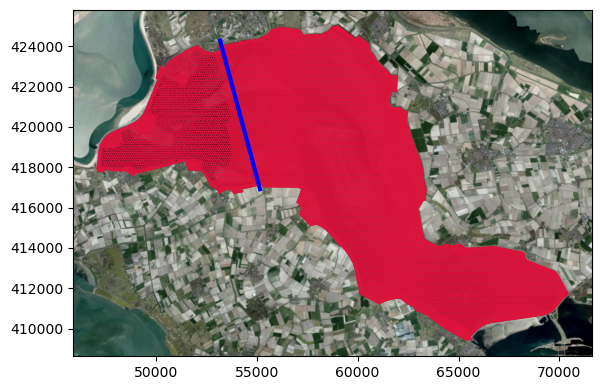

In [7]:
#plot net/grid
ugrid_all = dfmt.get_netdata(file_nc=file_nc_map)#,multipart=False)
fig, ax = plt.subplots(figsize=(10,4))
pc = dfmt.plot_netmapdata(ugrid_all.verts, values=None, ax=None, linewidth=0.5, color="crimson", facecolor="None")
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
if line_array is not None:
    ax.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)
fig.tight_layout()


processing mapdata from domain 0000 of 0007
varname: mesh2d_s1  (4, 6579)  ('time', 'nmesh2d_face'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0001 of 0007
varname: mesh2d_s1  (4, 6755)  ('time', 'nmesh2d_face'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0002 of 0007
varname: mesh2d_s1  (4, 5943)  ('time', 'nmesh2d_face'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0003 of 0007
varname: mesh2d_s1  (4, 6412)  ('time', 'nmesh2d_face'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0004 of 0007
varname: mesh2d_s1  (4, 5992)  ('time', 'nmesh2d_face'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0005 of 0007
varname: mesh2d_s1  (4, 6272)  ('time', 'nmesh2d_face'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0006 of 0007
varname: mesh2d_s1  (4, 6641)  ('time', 'nmesh2d_face'), coordinates=(mesh2d_face_x mesh2d_face_y)

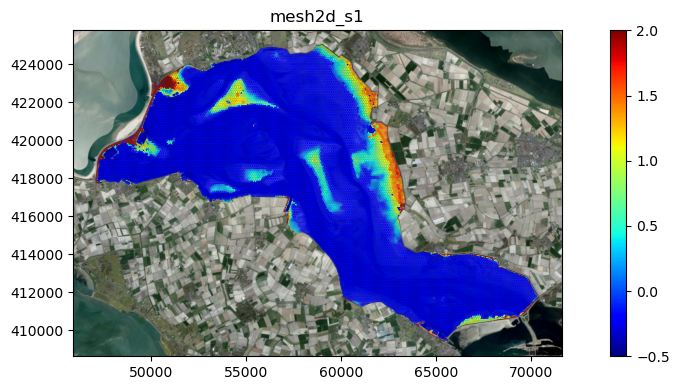

In [8]:
#plot water level on map
data_frommap_wl = dfmt.get_ncmodeldata(file_nc=file_nc_map, varname='mesh2d_s1', timestep=3)#, multipart=False)
fig, ax = plt.subplots(figsize=(10,4))
pc = dfmt.plot_netmapdata(ugrid_all.verts, values=data_frommap_wl[0,:], ax=None, linewidth=0.5, cmap="jet")
pc.set_clim([-0.5,2])
fig.colorbar(pc, ax=ax)
ax.set_title(data_frommap_wl.var_varname)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
fig.tight_layout()


processing mapdata from domain 0000 of 0007
varname: mesh2d_ucx  (4, 6579, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0001 of 0007
varname: mesh2d_ucx  (4, 6755, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0002 of 0007
varname: mesh2d_ucx  (4, 5943, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0003 of 0007
varname: mesh2d_ucx  (4, 6412, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0004 of 0007
varname: mesh2d_ucx  (4, 5992, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0005 of 0007
varname: mesh2d_ucx  (4, 6272, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing

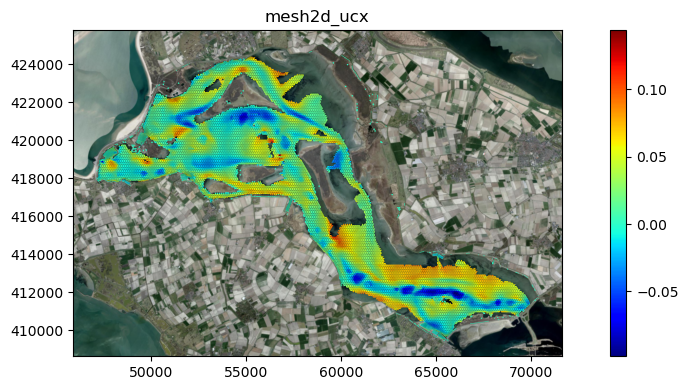

In [9]:
#plot eastward velocities on map
data_frommap_sal = dfmt.get_ncmodeldata(file_nc=file_nc_map, varname='mesh2d_ucx', timestep=3, layer=layer)#, multipart=False)
fig, ax = plt.subplots(figsize=(10,4))
pc = dfmt.plot_netmapdata(ugrid_all.verts, values=data_frommap_sal[0,:], ax=None, linewidth=0.5, cmap="jet")
fig.colorbar(pc, ax=ax)
ax.set_title(data_frommap_sal.var_varname)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
fig.tight_layout()

defining celinlinebox
finding crossing flow links (can take a while if linebox over xy covers a lot of cells, 3809 of 44796 cells are being processed)
calculating distance for all crossed cells, from first point of line (should not take long, but if it does, optimisation is needed)
finished calculating distance for all crossed cells, from first point of line
done finding crossing flow links: 169 of 44796
processing mapdata from domain 0000 of 0007
varname: mesh2d_s1  (4, 6579)  ('time', 'nmesh2d_face'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0001 of 0007
varname: mesh2d_s1  (4, 6755)  ('time', 'nmesh2d_face'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0002 of 0007
varname: mesh2d_s1  (4, 5943)  ('time', 'nmesh2d_face'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0003 of 0007
varname: mesh2d_s1  (4, 6412)  ('time', 'nmesh2d_face'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata f

c:\DATA\dfm_tools\dfm_tools\get_nc.py:426: UserWarning: WARNING: your model seems to contain only z-layers. if the modeloutput is generated with an older version of dflowfm, the coordinates can be incorrect. if your model contains z-sigma-layers, use the fulloutput option in the mdu and rerun (happens automatically in newer dflowfm versions).
  warnings.warn('WARNING: your model seems to contain only z-layers. if the modeloutput is generated with an older version of dflowfm, the coordinates can be incorrect. if your model contains z-sigma-layers, use the fulloutput option in the mdu and rerun (happens automatically in newer dflowfm versions).')


processing mapdata from domain 0000 of 0007
varname: mesh2d_sa1  (4, 6579, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0001 of 0007
varname: mesh2d_sa1  (4, 6755, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0002 of 0007
varname: mesh2d_sa1  (4, 5943, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0003 of 0007
varname: mesh2d_sa1  (4, 6412, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0004 of 0007
varname: mesh2d_sa1  (4, 5992, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing mapdata from domain 0005 of 0007
varname: mesh2d_sa1  (4, 6272, 36)  ('time', 'nmesh2d_face', 'nmesh2d_layer'), coordinates=(mesh2d_face_x mesh2d_face_y)
processing

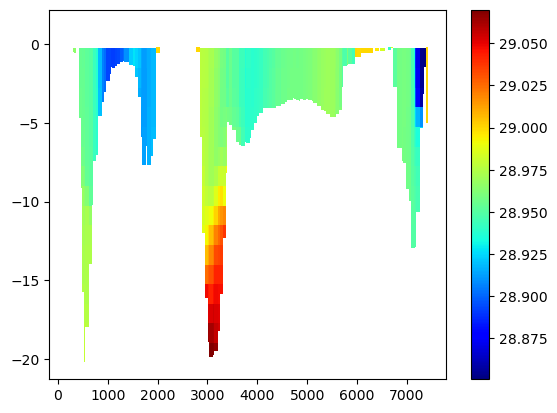

In [10]:
#plot slice/sideview trough 3D salinity mapdata
if line_array is not None:
    intersect_pd = ugrid_all.polygon_intersect(line_array, optimize_dist=False, calcdist_fromlatlon=None)
    #derive vertices from cross section (distance from first point)
    crs_verts, crs_plotdata = dfmt.get_xzcoords_onintersection(file_nc=file_nc_map, varname='mesh2d_sa1', intersect_pd=intersect_pd, timestep=3)
    fig, ax = plt.subplots()
    pc = dfmt.plot_netmapdata(crs_verts, values=crs_plotdata, ax=ax, cmap='jet')#, linewidth=0.5, edgecolor='k')
    fig.colorbar(pc, ax=ax)
